# Corrections

## Figures and tables included in the paper:
* [Table 1 (Main Face Study)](#tab1) 
* [Figure 1 (Main Face Study)](#fig1)
* [Figure 2 (Main Voice Study)](#fig2)

## Statistics mentioned in the paper:
* [Main Voice Study Model](#voice)
* [ANOVA Models](#anova)
* [Main Face Study Model with Order and Time](#ordertime)
* [Main Face Study Model with Order and Time and Stimulus as Random Factor](#ordertimestim)

## Importing the data

In [1]:
import pandas as pd
import numpy as np
from itertools import combinations
import rpy2

In [ ]:
%load_ext rpy2.ipython

In [3]:
# using the original dataset with the original variable names
face = pd.read_csv("data/main_study_face_data.csv")
voice = pd.read_csv("data/main_study_voice_data.csv")

The variable names used in original study versus our reproduction work:

In [4]:
pd.DataFrame({'Original Study Variable Names': ["id", "order", "prime", "masc", "stim", "cond"], 
              'Reproduction Work Variable Names': ["participant_id", "trial_number", "pre_post_prime", "chose_masc", "image", "prime_condition"]})

,Original Study Variable Names,Reproduction Work Variable Names
0,id,participant_id
1,order,trial_number
2,prime,pre_post_prime
3,masc,chose_masc
4,stim,image
5,cond,prime_condition


A mapping from the prime condition group number to the group name:

In [5]:
pd.DataFrame({'Prime condition group number': [1, 2, 3, 4, 5], 
              'Prime condition group name': ["Neutral (Control)", "Male-on-Male", "Male Intergroup", "Male-on-Female", "Pathogen"]})

,Prime condition group number,Prime condition group name
0,1,Neutral (Control)
1,2,Male-on-Male
2,3,Male Intergroup
3,4,Male-on-Female
4,5,Pathogen


## Fixing the datasets (duplicates and image 10 assignment)

Removing all of the duplicate participants:

In [6]:
def find_duplicates(data): 
    combs = combinations(list(data["id"].unique()), 2)
    matches = list()
    for ids in combs:
        id0_array = data[data["id"]==ids[0]].iloc[:, 1:].values
        id1_array = data[data["id"]==ids[1]].iloc[:, 1:].values
        if (ids[0] != ids[1]) and (id0_array.shape == id1_array.shape) and ((id0_array == id1_array).all()):
            matches.append((ids[0], ids[1]))
    return matches

In [7]:
# removing duplicates in face dataset
face_dups = find_duplicates(face)
face_dups_id = [dup[1] for dup in face_dups]
face_fixed = face[~face["id"].isin(face_dups_id)]
face_fixed = face_fixed.reset_index(drop=True)

In [8]:
# removing duplicates in voice dataset
voice_dups = find_duplicates(voice)
# only participants with a "b" in the name are assumed to be duplicates
# as the voice experiment had a much smaller number of trials (6), a repeated result could genuinely occur by chance
voice_dups_id = [dup[1] for dup in voice_dups if "b" in dup[1]]
voice_fixed = voice[~voice["id"].isin(voice_dups_id)]
voice_fixed = voice_fixed.reset_index(drop=True)

Fixing the image 10 mistake (the wrong side was assigned as masculine):

In [9]:
face_fixed.update(face_fixed[face_fixed["stim"]=="faces\Slide10.bmp"]["masc"].map({0:1, 1:0}))
face_fixed["masc"] = face_fixed["masc"].astype("int64")

## Recreating table 1 (main face study) <a name="tab1"></a>

In [11]:
%%R -i face_fixed -o model_df
library(nlme)
face_fixed$cond = as.factor(face_fixed$cond)
model <- lme(masc ~ prime*cond, random=~1|id, data=face_fixed)
model_df <- as.data.frame(coef(summary(model)))

In [12]:
face_table = model_df.reset_index()
face_table.columns=["", "Estimate", "SE", "df", "t-value", "p-value"]
face_table[""] = ["Intercept", "Time", "Male-on-Male", "Male Intergroup", "Male-on-Female", "Pathogen", "Time*Male-on-Male", "Time*Male Intergroup", "Time*Male-on-Female", "Time*Pathogen"]
face_table["df"] = face_table["df"].astype("int64")

In [13]:
with pd.option_context("display.float_format", "{:0.3f}".format):
    display(face_table)

,,Estimate,SE,df,t-value,p-value
0,Intercept,0.580,0.026,10845,22.602,0.000
1,Time,0.071,0.019,10845,3.626,0.000
2,Male-on-Male,-0.060,0.036,286,-1.638,0.102
3,Male Intergroup,-0.059,0.037,286,-1.590,0.113
4,Male-on-Female,-0.001,0.036,286,-0.021,0.983
5,Pathogen,-0.011,0.036,286,-0.296,0.767
6,Time*Male-on-Male,-0.022,0.028,10845,-0.775,0.439
7,Time*Male Intergroup,0.018,0.028,10845,0.657,0.511
8,Time*Male-on-Female,-0.078,0.027,10845,-2.823,0.005
9,Time*Pathogen,-0.039,0.028,10845,-1.413,0.158


## Recreating figure 1 (main face study) <a name="fig1"></a>

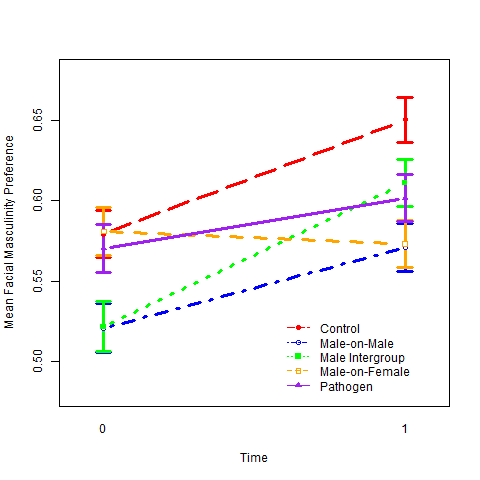

In [14]:
%%R -i face_fixed
library(sciplot)
face_fixed$cond = as.factor(face_fixed$cond)
plot <- lineplot.CI(x.factor=prime, response=masc, group=cond, data=face_fixed,
            xlab="Time", ylab="Mean Facial Masculinity Preference",
            fixed=T, x.leg=1.6, y.leg=0.53, ylim=c(0.48,0.68), lwd=3, col=c("red","blue","green","orange","purple"),
            leg.lab=c("Control","Male-on-Male",'Male Intergroup','Male-on-Female','Pathogen'))

## Recreating figure 2 (main voice study) <a name="fig2"></a>

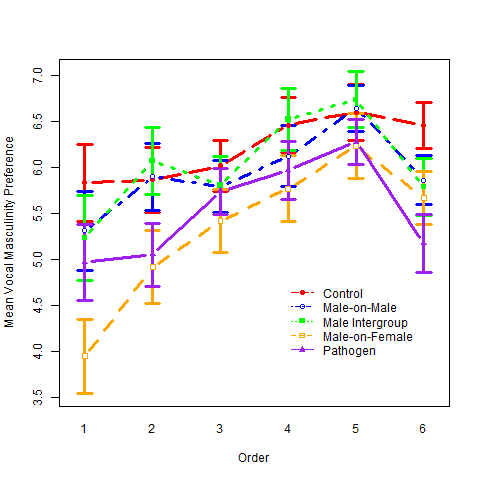

In [16]:
%%R -i voice_fixed
library(sciplot)
voice_fixed$cond = as.factor(voice_fixed$cond)
lineplot.CI(x.factor=order, response=masc, group=cond, data=voice_fixed,
            xlab="Order", ylab="Mean Vocal Masculinity Preference",
            fixed=T, x.leg=4, y.leg=4.8, lwd=3, col=c("red","blue","green","orange","purple"),
            leg.lab=c("Control","Male-on-Male",'Male Intergroup','Male-on-Female','Pathogen'))

## Main Voice Study Model <a name="voice"></a>

Model without interactions:

In [17]:
%%R -i voice_fixed -o model_df
library(nlme)
voice_fixed$cond = as.factor(voice_fixed$cond)
model <- lme(masc ~ order + cond, random=~1|id, data=voice_fixed, method="ML")
model_df <- as.data.frame(coef(summary(model)))

In [18]:
voice_table = model_df.reset_index()
voice_table.columns=["", "Estimate", "SE", "df", "t-value", "p-value"]
voice_table[""] = ["Intercept", "Order", "Male-on-Male", "Male Intergroup", "Male-on-Female", "Pathogen"]
voice_table["df"] = voice_table["df"].astype("int64")

In [19]:
with pd.option_context("display.float_format", "{:0.3f}".format):
    display(voice_table)

,,Estimate,SE,df,t-value,p-value
0,Intercept,5.512,0.216,1454,25.492,0.000
1,Order,0.198,0.033,1454,5.969,0.000
2,Male-on-Male,-0.267,0.259,286,-1.028,0.305
3,Male Intergroup,-0.180,0.262,286,-0.687,0.493
4,Male-on-Female,-0.878,0.257,286,-3.417,0.001
5,Pathogen,-0.675,0.259,286,-2.602,0.010


Model with interactions:

In [20]:
%%R -i voice_fixed -o model_df
library(nlme)
voice_fixed$cond = as.factor(voice_fixed$cond)
model <- lme(masc ~ order*cond, random=~1|id, data=voice_fixed, method="ML")
model_df <- as.data.frame(coef(summary(model)))

In [21]:
voice_table_int = model_df.reset_index()
voice_table_int.columns=["", "Estimate", "SE", "df", "t-value", "p-value"]
voice_table_int[""] = ["Intercept", "Order", "Male-on-Male", "Male Intergroup", "Male-on-Female", "Pathogen", "Order*Male-on-Male", "Order*Male Intergroup", "Order*Male-on-Female", "Order*Pathogen"]
voice_table_int["df"] = voice_table_int["df"].astype("int64")

In [22]:
with pd.option_context("display.float_format", "{:0.3f}".format):
    display(voice_table_int)

,,Estimate,SE,df,t-value,p-value
0,Intercept,5.627,0.315,1450,17.842,0.000
1,Order,0.165,0.073,1450,2.242,0.025
2,Male-on-Male,-0.221,0.448,286,-0.494,0.622
3,Male Intergroup,-0.150,0.452,286,-0.331,0.741
4,Male-on-Female,-1.590,0.444,286,-3.581,0.000
5,Pathogen,-0.591,0.448,286,-1.320,0.188
6,Order*Male-on-Male,-0.013,0.104,1450,-0.124,0.901
7,Order*Male Intergroup,-0.009,0.105,1450,-0.081,0.935
8,Order*Male-on-Female,0.203,0.103,1450,1.967,0.049
9,Order*Pathogen,-0.024,0.104,1450,-0.228,0.820


## ANOVA models  <a name="anova"></a>

ANOVA model for main face study:

In [23]:
%%R -i face_fixed
library(nlme)
face_fixed$cond = as.factor(face_fixed$cond)
anova(lme(masc ~ prime*cond, random=~1|id, data=face_fixed), type="marginal", adjustSigma=F)

            numDF denDF  F-value p-value
(Intercept)     1 10845 510.8395  <.0001
prime           1 10845  13.1460  0.0003
cond            4   286   1.3915  0.2369
prime:cond      4 10845   3.5530  0.0067


Priming group differences in face masculinity preference at pre-prime:

In [24]:
face_pre = face_fixed[face_fixed["prime"]==0]

In [25]:
%%R -i face_pre
library(nlme)
face_pre$cond = as.factor(face_pre$cond)
anova(lme(masc ~ cond, random=~1|id, data=face_pre), type="marginal", adjustSigma=F)

            numDF denDF  F-value p-value
(Intercept)     1  5176 569.5096  <.0001
cond            4   286   1.5480  0.1884


## Main face study model with order and time <a name="ordertime"></a>

In [26]:
%%R -i face_fixed -o model_df
library(nlme)
face_fixed$cond = as.factor(face_fixed$cond)
model <- lme(masc ~ order + prime*cond, random=~1|id, data=face_fixed)
model_df <- as.data.frame(coef(summary(model)))

In [27]:
order_time = model_df.reset_index()
order_time.columns=["", "Estimate", "SE", "df", "t-value", "p-value"]
order_time[""] = ["Intercept", "Order", "Time", "Male-on-Male", "Male Intergroup", "Male-on-Female", "Pathogen", "Time*Male-on-Male", "Time*Male Intergroup", "Time*Male-on-Female", "Time*Pathogen"]
order_time["df"] = order_time["df"].astype("int64")

In [28]:
with pd.option_context("display.float_format", "{:0.3f}".format):
    display(order_time)

,,Estimate,SE,df,t-value,p-value
0,Intercept,0.551,0.027,10844,20.434,0.000
1,Order,0.003,0.001,10844,3.547,0.000
2,Time,0.017,0.025,10844,0.673,0.501
3,Male-on-Male,-0.060,0.036,286,-1.638,0.102
4,Male Intergroup,-0.059,0.037,286,-1.593,0.112
5,Male-on-Female,-0.001,0.036,286,-0.024,0.981
6,Pathogen,-0.011,0.036,286,-0.296,0.768
7,Time*Male-on-Male,-0.022,0.028,10844,-0.779,0.436
8,Time*Male Intergroup,0.019,0.028,10844,0.661,0.508
9,Time*Male-on-Female,-0.078,0.027,10844,-2.829,0.005


## Main face study model with order and time and stimulus as random factor <a name="ordertimestim"></a>

In [31]:
%%R -i face_fixed -o model_df
library(lme4)
face_fixed$cond = as.factor(face_fixed$cond)
model <- glmer(masc ~ order + prime*cond + (1|id) + (1|stim), data=face_fixed, family=binomial)
model_df <- as.data.frame(coef(summary(model)))

In [32]:
order_time_stim = model_df.reset_index()
order_time_stim.columns=["", "Estimate", "SE", "z-value", "p-value"]
order_time_stim[""] = ["Intercept", "Order", "Time", "Male-on-Male", "Male Intergroup", "Male-on-Female", "Pathogen", "Time*Male-on-Male", "Time*Male Intergroup", "Time*Male-on-Female", "Time*Pathogen"]

In [33]:
with pd.option_context("display.float_format", "{:0.3f}".format):
    display(order_time_stim)

,,Estimate,SE,z-value,p-value
0,Intercept,0.244,0.201,1.214,0.225
1,Order,0.014,0.004,3.721,0.000
2,Time,0.097,0.121,0.801,0.423
3,Male-on-Male,-0.282,0.183,-1.540,0.124
4,Male Intergroup,-0.296,0.185,-1.596,0.110
5,Male-on-Female,0.003,0.182,0.017,0.986
6,Pathogen,-0.043,0.183,-0.235,0.814
7,Time*Male-on-Male,-0.126,0.135,-0.934,0.350
8,Time*Male Intergroup,0.089,0.137,0.650,0.516
9,Time*Male-on-Female,-0.402,0.134,-3.008,0.003
